
# Training a SFNO on the spherical Shallow Water equations

Using the small Spherical Shallow Water Equations example we ship with the package
to train a Spherical Fourier-Neural Operator


In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Loading the Spherical Shallow Water Equations in multiple resolutions



In [2]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


We create a spherical FNO model



In [3]:
model = SFNO(n_modes=(32, 32),
             in_channels=3,
             out_channels=3,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 275555 parameters.


Create the optimizer



In [4]:
optimizer = AdamW(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [5]:
l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [6]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(5, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projectio

Create the trainer



In [7]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

Train the model on the spherical SWE dataset



In [8]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 200 samples
Testing on [50, 50] samples         on resolutions [(32, 64), (64, 128)].
Raw outputs of shape torch.Size([4, 3, 32, 64])
[0] time=8.23, avg_loss=2.6257, train_err=10.5027
Eval: (32, 64)_l2=2.1175, (64, 128)_l2=2.3685
[3] time=8.40, avg_loss=0.4262, train_err=1.7049
Eval: (32, 64)_l2=0.6080, (64, 128)_l2=2.5609
[6] time=8.31, avg_loss=0.2799, train_err=1.1195
Eval: (32, 64)_l2=0.5316, (64, 128)_l2=2.4933
[9] time=7.41, avg_loss=0.2389, train_err=0.9556
Eval: (32, 64)_l2=0.4285, (64, 128)_l2=2.4615
[12] time=7.87, avg_loss=0.2010, train_err=0.8042
Eval: (32, 64)_l2=0.4441, (64, 128)_l2=2.4922
[15] time=9.06, avg_loss=0.1888, train_err=0.7553
Eval: (32, 64)_l2=0.4179, (64, 128)_l2=2.4527
[18] time=8.26, avg_loss=0.1571, train_err=0.6285
Eval: (32, 64)_l2=0.4136, (64, 128)_l2=2.4491


{'train_err': 0.6102407872676849,
 'avg_loss': 0.15256019681692123,
 'avg_lasso_loss': None,
 'epoch_train_time': 8.087722900003428}

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



C:\Users\alfre\AppData\Local\Temp\ipykernel_11348\2782922215.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


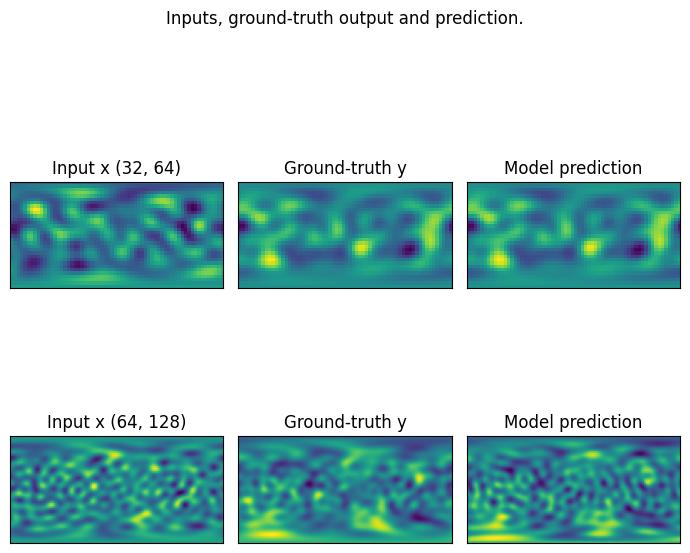

In [9]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y'][0, ...].numpy()
    # Model prediction
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()